In [ ]:
########################################
## cell 1
########################################

# https://trends.google.com/trending?geo=US&hours=168
# libraries for real-time google trends data crawling!pip install playwright
!pip install playwright
!playwright install chromium
!playwright install-deps
!pip install sentence-transformers pandas numpy scikit-learn matplotlib seaborn

import asyncio
from playwright.async_api import async_playwright
import pandas as pd

import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import Counter, defaultdict
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

Installing dependencies...
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,961 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,598 kB]
Fetched 5,688 kB in 4s 

In [ ]:
########################################
## cell 2     Crawling     Sunghyun Kim
########################################

# scraping real-time data from Google Trends. Estimate running time: 8 minutes
async def real_time_google_trends():
    async with async_playwright() as p:
        browser = await p.chromium.launch(
            headless=True,
        )
        context = await browser.new_context()
        page = await context.new_page()

        page.set_default_timeout(15000)

        url = "https://trends.google.com/trending?geo=US&hours=168"
        await page.goto(url, wait_until="domcontentloaded")

        # change row 25 into 50
        await page.wait_for_selector('tbody[jsname="cC57zf"] tr[jsname="oKdM2c"]', timeout=20000)

        try:
            rows_per_page_box = page.locator('div[role="combobox"]').first
            await rows_per_page_box.click()
            await page.wait_for_timeout(500)

            option_50 = page.locator('div[role="option"] >> text=50')
            await option_50.click()
            await page.wait_for_timeout(1500)
        except Exception:
            pass
        # save to list
        trends = []
        search_volume = []
        started = []

        while True:
            # count and wait rows
            try:
                await page.wait_for_selector(
                    'tbody[jsname="cC57zf"] tr[jsname="oKdM2c"]',
                    timeout=15000
                )
            except Exception:
                break

            rows = page.locator('tbody[jsname="cC57zf"] tr[jsname="oKdM2c"]')
            count = await rows.count()
            if count == 0:
                break

            # scrap datas
            for i in range(count):
                row = rows.nth(i)
                trends_el = row.locator(".mZ3RIc")
                volume_el = row.locator(".lqv0Cb")
                started_el = row.locator(".vdw3Ld")

                # trends
                if await trends_el.count() > 0:
                    trend = (await trends_el.inner_text()).strip()
                    trends.append(trend)
                # search volume
                if await volume_el.count() > 0:
                    volume = (await volume_el.inner_text()).strip()
                    search_volume.append(volume)
                # started
                if await started_el.count() > 0:
                    start = (await started_el.inner_text()).strip()
                    started.append(start)

            # go to next page
            next_button = page.locator('button[aria-label="Go to next page"]')
            if await next_button.count() == 0 or not await next_button.is_enabled():
                break

            try:
                await page.evaluate("""
                () => {
                    const btn = document.querySelector('button[aria-label="Go to next page"]');
                    if (btn) btn.click();
                }
                """)
                await page.wait_for_timeout(2000)
            except Exception:
                break

            if len(trends) > 1799:
                break

        print("total:", len(trends))
        print("trends:", trends)
        print("volume total:", len(search_volume))
        print("search volume:", search_volume)
        print("started total:", len(started))
        print("started", started)

        # make list to dataframe
        df = pd.DataFrame({
            "Trends": trends,
            "Search volume": search_volume,
            "Started": started,
        })

        print(df)

        await browser.close()

        return df
df_trends_realtime = await real_time_google_trends()  # pyright: ignore


total: 1800
trends: ['sherrone moore', 'philip rivers', 'falcons vs buccaneers', 'andy dick', 'eagles vs chargers', 'game awards 2025', 'iron lung movie', 'fifa', 'tigres - toluca', 'supergirl', 'que', 'wenne alton davis', 'jay kelly', 'spurs vs lakers', 'celtics vs bucks', 'dicks sporting good', 'pete alonso', 'mike evans', 'iowa vs iowa state', 'clippers vs rockets', 'jeff garcia', 'jason collins', 'sophie kinsella', 'star wars fate of the old republic', 'real madrid vs man city', 'flood warning', 'tj watt', 'divinity', 'kelly osbourne', 'nick fuentes', 'kyle rittenhouse', 'forest 3', 'jasmine crockett', 'nuggets vs kings', 'zendaya', 'trail blazers vs pelicans', 'percy jackson season 2', 'diablo 4', 'dan crenshaw', 'avengers doomsday trailer', 'esdeekid', 'playstation wrapped', 'tomb raider', 'werner herzog', 'jennifer english', 'street fighter movie 2026', 'calibri font', 'oracle stock', 'ben starr', 'kyle pitts stats', 'time person of the year 2025', 'tina peters', 'tyler robinson

In [ ]:
########################################
## cell 3   Wikipedia Loader     Sunghyun Kim
########################################

class WikipediaLoader:
    def __init__(self, hf_dataset, max_docs: int = None, min_tokens: int = 5):
        titles = hf_dataset["title"]
        texts = hf_dataset["text"]

        processed = []
        for t, txt in zip(titles, texts):
            if not isinstance(txt, str) or not txt.strip():
                continue

            first_par = txt.split("\n\n", 1)[0]
            full = f"{t} {first_par}".strip()

            if len(full.split()) < min_tokens:
                continue

            processed.append({"title": t, "text": full})

            if max_docs is not None and len(processed) >= max_docs:
                break

        self.df = pd.DataFrame(processed)
        self.texts = self.df["text"].tolist()
        self.titles = self.df["title"].tolist()

    def __len__(self):
        return len(self.texts)

    def get_texts(self):
        return self.texts

    def get_titles(self):
        return self.titles


In [ ]:
########################################
## cell 4     Wikipedia Data Loading     Sunghyun Kim
########################################
# Estimate running time: 10 minutes
from datasets import load_dataset

wiki_raw = load_dataset("wikimedia/wikipedia", "20231101.en", split="train[:1%]")
wiki_loader = WikipediaLoader(wiki_raw, max_docs=10000)
print("num wiki docs:", len(wiki_loader))
print("sample:", wiki_loader.get_texts()[0][:200])


Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

num wiki docs: 10000
sample: Anarchism Anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hiera


In [ ]:
########################################
## cell 5     Google Trends Loader     Sunghyun Kim
########################################
class GoogleTrendsLoader:

    def __init__(self):
        self.keywords = []
        self.df = None
        self.timestamp = None
        self.search_volumes = {}
        self.related_keywords = {}
        self.started_times = {}
        self.keyword_type = {}
        self.parent_keyword = {}

    def parse_volume(self, volume_str: str) -> float:
        if pd.isna(volume_str) or not volume_str:
            return 50.0

        volume_str = (
            str(volume_str)
            .strip()
            .upper()
            .replace('+', '')
            .replace(',', '')
        )

        try:
            if 'M' in volume_str:
                return float(volume_str.replace('M', '')) * 1_000_000
            elif 'K' in volume_str:
                return float(volume_str.replace('K', '')) * 1_000
            else:
                return float(volume_str)
        except Exception:
            return 50.0

    def parse_datetime(self, date_str: str) -> datetime:
        if pd.isna(date_str) or not date_str:
            return datetime.now()

        s = str(date_str).strip().lower()
        now = datetime.now()

        if s == "yesterday":
            return now - timedelta(days=1)

        m = re.match(r"(\d+)\s+(minute|minutes|hour|hours|day|days)\s+ago", s)
        if m:
            value = int(m.group(1))
            unit = m.group(2)

            if "minute" in unit:
                delta = timedelta(minutes=value)
            elif "hour" in unit:
                delta = timedelta(hours=value)
            else:  # day / days
                delta = timedelta(days=value)

            return now - delta

        try:
            return pd.to_datetime(s).to_pydatetime()
        except Exception:
            return now

    def _load_from_df(self, df: pd.DataFrame, source_label: str = "Google Trends"):
        try:
            self.df = df
            self.timestamp = datetime.now()

            possible_cols = ['Trends', 'trends', 'TRENDS', 'keyword', 'Keyword', 'term', 'Term']
            keyword_col = None
            for col in possible_cols:
                if col in self.df.columns:
                    keyword_col = col
                    break
            if keyword_col is None:
                keyword_col = self.df.columns[1] if len(self.df.columns) > 1 else self.df.columns[0]

            has_volume = 'Search volume' in self.df.columns
            has_started = 'Started' in self.df.columns
            breakdown_col = 'Trend breakdown' if 'Trend breakdown' in self.df.columns else None

            print(f"\nLoading data from: {source_label}")

            self.keywords = []
            self.search_volumes.clear()
            self.related_keywords.clear()
            self.started_times.clear()
            self.keyword_type.clear()
            self.parent_keyword.clear()

            main_count = 0
            breakdown_new_count = 0

            for _, row in self.df.iterrows():
                main_kw = str(row[keyword_col]).strip() if pd.notna(row[keyword_col]) else ""
                if not main_kw:
                    continue

                if main_kw not in self.keyword_type:
                    self.keywords.append(main_kw)
                    self.keyword_type[main_kw] = 'main'
                    main_count += 1

                vol = self.parse_volume(row['Search volume']) if has_volume else 50.0
                started = self.parse_datetime(row['Started']) if has_started else self.timestamp

                if main_kw not in self.search_volumes:
                    self.search_volumes[main_kw] = vol
                else:
                    self.search_volumes[main_kw] = max(self.search_volumes[main_kw], vol)

                if main_kw not in self.started_times:
                    self.started_times[main_kw] = started
                else:
                    if started > self.started_times[main_kw]:
                        self.started_times[main_kw] = started

                related_list = []
                if breakdown_col and pd.notna(row[breakdown_col]) and str(row[breakdown_col]).strip():
                    tokens = [t.strip() for t in str(row[breakdown_col]).split(',') if t.strip()]
                    for bk in tokens:
                        if not bk or bk == main_kw:
                            continue
                        related_list.append(bk)

                        if bk not in self.keyword_type:
                            self.keywords.append(bk)
                            self.keyword_type[bk] = 'breakdown'
                            self.parent_keyword[bk] = main_kw
                            breakdown_new_count += 1

                            self.search_volumes[bk] = vol
                            self.started_times[bk] = started

                if related_list:
                    self.related_keywords[main_kw] = related_list[:30]

            print(f"\nLoaded {len(self.keywords)} total keywords ")

            if self.search_volumes:
                avg_volume = np.mean(list(self.search_volumes.values()))
            if self.related_keywords:
                avg_related = np.mean([len(v) for v in self.related_keywords.values()])
                print(f"Avg Related Keywords (per main trend): {avg_related:.1f}")

            return self.keywords

        except Exception as e:
            print(f"Error loading DataFrame: {e}")
            raise

    def load_csv(self, filepath: str, encoding: str = 'utf-8') -> List[str]:
        try:
            df = pd.read_csv(filepath, encoding=encoding)
            return self._load_from_df(df, source_label=f"Google Trends CSV ({filepath})")
        except Exception as e:
            print(f"Error loading CSV: {e}")
            raise

    def load_df(self, df: pd.DataFrame) -> List[str]:
        try:
            return self._load_from_df(df, source_label="Real-time Google Trends (Playwright)")
        except Exception as e:
            print(f"Error loading DataFrame: {e}")
            raise

    def get_keywords(self) -> List[str]:
        return self.keywords

    def get_search_volume(self, keyword: str) -> float:
        return self.search_volumes.get(keyword, 50.0)

    def get_related_keywords(self, keyword: str) -> List[str]:
        return self.related_keywords.get(keyword, [])

    def get_started_time(self, keyword: str) -> datetime:
        return self.started_times.get(keyword, self.timestamp or datetime.now())

    def get_keyword_metadata(self, keyword: str) -> Dict:
        return {
            'keyword': keyword,
            'search_volume': self.get_search_volume(keyword),
            'started_time': self.get_started_time(keyword),
            'type': self.keyword_type.get(keyword, 'unknown'),
            'parent_keyword': self.parent_keyword.get(keyword),
            'related_keywords': self.get_related_keywords(keyword),
            'first_seen': self.timestamp,
        }

loader = GoogleTrendsLoader()


In [ ]:
########################################
## cell 6     SBERT Embedding Engine (caching)     Jaemin Shin
########################################
class EmbeddingEngine:

    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)
        self.cache = {}
        self.cache_hits = 0
        self.cache_misses = 0
        print("Model loaded!")

    def encode(self, text: str):
        if text in self.cache:
            self.cache_hits += 1
            return self.cache[text]

        self.cache_misses += 1
        emb = self.model.encode(text, convert_to_numpy=True)
        self.cache[text] = emb
        return emb

    def encode_batch(self, texts: List[str]):
        new_texts = [t for t in texts if t not in self.cache]

        if new_texts:
            new_embs = self.model.encode(new_texts, convert_to_numpy=True, show_progress_bar=False)
            for text, emb in zip(new_texts, new_embs):
                self.cache[text] = emb
            self.cache_misses += len(new_texts)

        self.cache_hits += len(texts) - len(new_texts)
        return np.array([self.cache[t] for t in texts])

    def get_cache_stats(self):
        total = self.cache_hits + self.cache_misses
        hit_rate = self.cache_hits / total if total > 0 else 0
        return {
            'cache_size': len(self.cache),
            'cache_hits': self.cache_hits,
            'cache_misses': self.cache_misses,
            'hit_rate': hit_rate
        }

    def compute_user_profile_embedding(self, past_queries: List[str]):
        if not past_queries:
            return np.zeros(384)

        query_embs = self.encode_batch(past_queries[-20:])
        return query_embs.mean(axis=0)

embedding_engine = EmbeddingEngine()

Model loaded!


In [ ]:
########################################
## cell 7     Advanced Popularity Model (uses search volume)     Jaemin Shin
########################################
class AdvancedPopularityModel:

    def __init__(
        self,
        decay_lambda: float = 0.05,
        volume_scale: float = 30.0,
        view_bonus_slope: float = 2.0,
        view_bonus_max: float = 20.0,
        length_base: float = 100.0,
        uniqueness_bonus: float = 20.0,
        common_word_penalty: float = 10.0,
        ):

        self.decay_lambda = decay_lambda

        self.volume_scale = volume_scale

        self.view_bonus_slope = view_bonus_slope
        self.view_bonus_max = view_bonus_max

        self.length_base = length_base
        self.uniqueness_bonus = uniqueness_bonus
        self.common_word_penalty = common_word_penalty

        self.keyword_metadata = {}
        self.loader = None

    def set_loader(self, loader):
        self.loader = loader

    def compute_web_volume_proxy(self, keyword: str):
        length_score = self.length_base / (len(keyword.split()) + 1)
        has_caps = any(c.isupper() for c in keyword)
        has_nums = any(c.isdigit() for c in keyword)
        uniqueness_score = self.uniqueness_bonus if (has_caps or has_nums) else 0

        common_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for'}
        word_penalty = sum(self.common_word_penalty for w in keyword.lower().split() if w in common_words)

        score = length_score + uniqueness_score - word_penalty
        return max(0, min(100, score))

    def compute_time_decayed_popularity(self, keyword: str, base_popularity: float, current_time: datetime):
        if keyword not in self.keyword_metadata:
            return base_popularity

        first_seen = self.keyword_metadata[keyword]['first_seen']
        hours_since = (current_time - first_seen).total_seconds() / 3600

        decayed = base_popularity * np.exp(-self.decay_lambda * hours_since)
        return decayed

    def compute_final_popularity(self, keyword: str, timestamp: datetime = None):
        current_time = timestamp or datetime.now()
        if self.loader and hasattr(self.loader, 'search_volumes'):
            real_volume = self.loader.get_search_volume(keyword)

            if real_volume > 0:
                base_popularity = self.volume_scale * np.log10(real_volume + 1)
            else:
                base_popularity = self.compute_web_volume_proxy(keyword)
        else:
            base_popularity = self.compute_web_volume_proxy(keyword)

        if keyword not in self.keyword_metadata:
            if self.loader and hasattr(self.loader, 'started_times'):
                started_time = self.loader.get_started_time(keyword)
            else:
                started_time = current_time

            self.keyword_metadata[keyword] = {
                'first_seen': started_time,
                'base_popularity': base_popularity,
                'view_count': 1,
                'real_volume': real_volume if self.loader else None
            }
        else:
            self.keyword_metadata[keyword]['view_count'] += 1

        view_count = self.keyword_metadata[keyword]['view_count']
        view_bonus = min(view_count * self.view_bonus_slope, self.view_bonus_max)

        final_base = base_popularity + view_bonus

        final_popularity = self.compute_time_decayed_popularity(keyword, final_base, current_time)

        return final_popularity

    def get_popularity_batch(self, keywords: List[str], timestamp: datetime = None):
        return np.array([self.compute_final_popularity(kw, timestamp) for kw in keywords])

popularity_model = AdvancedPopularityModel(decay_lambda=0.03)

In [ ]:
########################################
## cell 8     Create Wikipedia Embeddings     Sunghyun Kim
########################################
# Estimate running time: 10 minutes

wiki_texts = wiki_loader.get_texts()
BATCH_SIZE = 512
emb_list = []

for i in range(0, len(wiki_texts), BATCH_SIZE):
    batch = wiki_texts[i:i+BATCH_SIZE]
    batch_embs = embedding_engine.encode_batch(batch)
    emb_list.append(batch_embs)

wiki_embs = np.vstack(emb_list)

print("wiki_embs shape:", wiki_embs.shape)


wiki_embs shape: (10000, 384)


In [ ]:
########################################
## cell 9     Domain Clustering Engine     Jaemin Shin
########################################
class DomainClusterEngine:

    def __init__(self, embedding_engine):
        self.embedding_engine = embedding_engine
        self.cluster_centers = None
        self.cluster_labels = None
        self.n_clusters = 0
        self.cluster_keywords = defaultdict(list)

    def build_clusters(self, keywords: List[str], n_clusters: int = 15):
        if not keywords or len(keywords) == 0:
            print("No keywords provided for clustering")
            return

        actual_clusters = min(n_clusters, len(keywords))

        if actual_clusters < 2:
            print(f"Too few keywords ({len(keywords)}) for clustering.")
            self.cluster_labels = np.zeros(len(keywords), dtype=int)
            self.n_clusters = 1
            self.cluster_keywords[0] = keywords
            return

        if actual_clusters < n_clusters:
            print(f"Adjusted n_clusters: {n_clusters} → {actual_clusters} (limited by keyword count)")

        embeddings = self.embedding_engine.encode_batch(keywords)

        kmeans = KMeans(n_clusters=actual_clusters, random_state=42, n_init=10)
        self.cluster_labels = kmeans.fit_predict(embeddings)
        self.cluster_centers = kmeans.cluster_centers_
        self.n_clusters = actual_clusters

        self.cluster_keywords.clear()
        for keyword, label in zip(keywords, self.cluster_labels):
            self.cluster_keywords[label].append(keyword)

        cluster_counts = Counter(self.cluster_labels)
        print(f"\nCluster Distribution:")
        for i in range(actual_clusters):
            count = cluster_counts.get(i, 0)
            sample_keywords = self.cluster_keywords[i][:3]
            print(f"   Cluster {i+1:2d}: {count:3d} keywords | Sample: {', '.join(sample_keywords)}")

    def find_best_cluster(self, category: str):
        if self.cluster_centers is None or len(self.cluster_centers) == 0:
            return 0

        category_emb = self.embedding_engine.encode(category)
        similarities = cosine_similarity([category_emb], self.cluster_centers)[0]
        return int(np.argmax(similarities))

    def get_cluster_representative_keywords(self, cluster_id: int, top_k: int = 5):
        if cluster_id not in self.cluster_keywords:
            return []

        cluster_kws = self.cluster_keywords[cluster_id]

        if not cluster_kws:
            return []

        if self.cluster_centers is None:
            return cluster_kws[:top_k]

        cluster_center = self.cluster_centers[cluster_id]

        kw_embs = self.embedding_engine.encode_batch(cluster_kws)
        similarities = cosine_similarity([cluster_center], kw_embs)[0]
        top_indices = np.argsort(-similarities)[:min(top_k, len(cluster_kws))]

        return [cluster_kws[i] for i in top_indices]

cluster_engine = DomainClusterEngine(embedding_engine)

In [ ]:
########################################
## cell 11  Zero-Shot Recommendation     Jaemin Shin
########################################

def is_broad_category(text: str) -> bool:
    tokens = text.strip().split()
    return len(tokens) == 1 and len(tokens[0]) >= 3


class ZeroShotRecommendation:

    def __init__(self, embedding_engine, cluster_engine, popularity_model):
        self.embedding_engine = embedding_engine
        self.cluster_engine = cluster_engine
        self.popularity_model = popularity_model
        self.loader = None

        self.query_logs = []

        self.recency_decay_rate = 0.10
        self.recency_scale = 100.0

    def set_loader(self, loader):
        self.loader = loader
        self.popularity_model.set_loader(loader)

    def recommend(
        self,
        user_category: str,
        keywords: List[str],
        top_k: int = 20,
        similarity_weight: float | None = None,
        popularity_weight: float | None = None,
        recency_weight: float | None = None,
        min_similarity: float | None = None,
        advanced_params: Dict[str, float] | None = None,
        force_mode: str | None = None,
    ):
        start_time = datetime.now()

        if advanced_params is None:
            advanced_params = {}

        recency_decay_rate = advanced_params.get(
            "recency_decay_rate", self.recency_decay_rate
        )
        recency_scale = advanced_params.get(
            "recency_scale", self.recency_scale
        )

        pop_decay_lambda = advanced_params.get("pop_decay_lambda", 0.0)
        volume_scale     = advanced_params.get("volume_scale", 10.0)
        view_bonus_slope = advanced_params.get("view_bonus_slope", 2.0)
        view_bonus_max   = advanced_params.get("view_bonus_max", 20.0)
        length_base      = advanced_params.get("length_base", 80.0)
        uniq_bonus       = advanced_params.get("uniq_bonus", 20.0)
        word_penalty     = advanced_params.get("word_penalty", 10.0)

        if min_similarity is None:
            min_similarity = 0.25

        if not keywords:
            return {
                "query": user_category,
                "results": [],
                "error": "No keywords provided",
                "status": "error",
            }

        if force_mode == "broad":
            broad = True
        elif force_mode == "specific":
            broad = False
        else:
            broad = is_broad_category(user_category.lower())

        if broad:
            if similarity_weight is None:
                similarity_weight = 0.60
            if popularity_weight is None:
                popularity_weight = 0.30
            if recency_weight is None:
                recency_weight = 0.10
        else:
            if similarity_weight is None:
                similarity_weight = 0.70
            if popularity_weight is None:
                popularity_weight = 0.20
            if recency_weight is None:
                recency_weight = 0.10

        print(
            f"Weights: α={similarity_weight}, β={popularity_weight}, γ={recency_weight}"
        )
        print(f"Mode: {'BROAD' if broad else 'SPECIFIC'} (force_mode={force_mode})")

        query_emb = self.embedding_engine.encode(user_category)
        keyword_embs = self.embedding_engine.encode_batch(keywords)
        similarities = cosine_similarity([query_emb], keyword_embs)[0]

        penalty_factor = 0.7
        query_tokens = set(user_category.lower().split())
        lex_factor = np.ones_like(similarities)

        for i, kw in enumerate(keywords):
            kw_tokens = set(kw.lower().split())
            if query_tokens & kw_tokens:
                lex_factor[i] = penalty_factor

        similarities = similarities * lex_factor

        max_similarity = float(np.max(similarities))
        mean_similarity = float(np.mean(similarities))
        median_similarity = float(np.median(similarities))
        top_10_similarities = sorted(similarities, reverse=True)[: min(10, len(similarities))]
        top_10_avg = float(np.mean(top_10_similarities)) if top_10_similarities else 0.0

        warning_level = None
        warning_message = None

        if max_similarity < 0.30:
            warning_level = "SEVERE"
            warning_message = "Very few relevant keywords in dataset"
        elif max_similarity < 0.50:
            warning_level = "MODERATE"
            warning_message = "Limited direct matches found"
        elif top_10_avg < 0.55:
            warning_level = "WEAK"
            warning_message = "Results show weak semantic connections (indirect/contextual)"
        elif mean_similarity < 0.25:
            warning_level = "MILD"
            warning_message = "Overall similarity is below average"

        if warning_level:
            label = {
                "SEVERE": "SEVERE - Very Low Similarity",
                "MODERATE": "MODERATE - Limited Direct Matches",
                "WEAK": "Weak Semantic Connections",
                "MILD": "Below-Average Quality",
            }[warning_level]
            print(label)
            print("=" * 70)
            print("Similarity Analysis:")
            print(f"   • Max Similarity: {max_similarity:.3f}")
            print(f"   • Top 10 Average: {top_10_avg:.3f}")
            print(f"   • Mean Similarity: {mean_similarity:.3f}")
            print(f"   • Issue: {warning_message}")
            print("=" * 70, "\n")
        else:
            print("Good similarity scores detected!")
            print(f"   • Max Similarity: {max_similarity:.3f}")
            print(f"   • Top 10 Average: {top_10_avg:.3f}")
            print(f"   • Mean Similarity: {mean_similarity:.3f}\n")

        print(f"Min similarity threshold = {min_similarity:.3f}")

        valid_indices = np.where(similarities >= min_similarity)[0]
        if len(valid_indices) == 0:
            print(f"No keywords above threshold ({min_similarity}) -> use every keywords")
            valid_indices = np.arange(len(keywords))
        else:
            print(f"Filtered: {len(valid_indices)}/{len(keywords)} keywords above threshold\n")

        filtered_keywords = [keywords[i] for i in valid_indices]
        filtered_sims = similarities[valid_indices]

        if self.loader is not None:
            popularity_scores = self.popularity_model.get_popularity_batch(
                filtered_keywords, self.loader.timestamp
            )
            popularity_scores = np.array(popularity_scores, dtype=float)

            if pop_decay_lambda > 0:
                popularity_scores = np.power(popularity_scores, 1.0 - pop_decay_lambda)
            if volume_scale > 0:
                popularity_scores = popularity_scores / volume_scale

            recency_scores = []
            for kw in filtered_keywords:
                started_time = self.loader.get_started_time(kw)
                hours_ago = (datetime.now() - started_time).total_seconds() / 3600.0

                if recency_decay_rate <= 0:
                    recency = recency_scale
                else:
                    recency = recency_scale * np.exp(-recency_decay_rate * hours_ago)

                recency_scores.append(recency)

            recency_scores = np.array(recency_scores, dtype=float)

        else:
            popularity_scores = np.ones(len(filtered_keywords)) * 50
            recency_scores = np.ones(len(filtered_keywords)) * 50

        clusters = []
        if self.cluster_engine.cluster_labels is not None:
            for i in range(len(filtered_keywords)):
                original_idx = valid_indices[i]
                clusters.append(int(self.cluster_engine.cluster_labels[original_idx]))
        else:
            clusters = [None] * len(filtered_keywords)

        def normalize(arr):
            if len(arr) == 0 or arr.max() == arr.min():
                return np.zeros_like(arr)
            return (arr - arr.min()) / (arr.max() - arr.min() + 1e-12)

        norm_sims = normalize(filtered_sims)
        norm_pops = normalize(popularity_scores)
        norm_recs = normalize(recency_scores)

        final_scores = (
            similarity_weight * norm_sims
            + popularity_weight * norm_pops
            + recency_weight * norm_recs
        )

        actual_k = min(top_k, len(filtered_keywords))
        top_indices = np.argsort(-final_scores)[:actual_k]

        results = []
        for rank, idx in enumerate(top_indices, 1):
            results.append(
                {
                    "rank": rank,
                    "keyword": filtered_keywords[idx],
                    "similarity": float(filtered_sims[idx]),
                    "popularity": float(popularity_scores[idx]),
                    "recency": float(recency_scores[idx]),
                    "final_score": float(final_scores[idx]),
                    "cluster": clusters[idx],
                }
            )

        elapsed = (datetime.now() - start_time).total_seconds()
        print(f"Returned {len(results)} keywords")

        if results:
            avg_sim = float(np.mean([r["similarity"] for r in results]))
            avg_pop = float(np.mean([r["popularity"] for r in results]))
        else:
            avg_sim = 0.0
            avg_pop = 0.0

        self.query_logs.append({
            "timestamp": datetime.now(),
            "query": user_category,
            "avg_similarity": avg_sim,
            "avg_popularity": avg_pop,
            "num_results": len(results),
            "elapsed_time": elapsed,
            "warning_level": warning_level,
            "weights": {
                "similarity": similarity_weight,
                "popularity": popularity_weight,
                "recency": recency_weight,
            },
            "min_similarity": min_similarity,
            "force_mode": force_mode,
            "detected_categories": [],
        })

        return {
            "query": user_category,
            "results": results,
            "total_keywords": len(keywords),
            "filtered_keywords": len(filtered_keywords),
            "method": "Simple Zero-Shot (sim+pop+rec)",
            "weights": {
                "similarity": similarity_weight,
                "popularity": popularity_weight,
                "recency": recency_weight,
            },
            "elapsed_time": elapsed,
            "similarity_stats": {
                "max": max_similarity,
                "mean": mean_similarity,
                "median": median_similarity,
                "top_10_avg": top_10_avg,
            },
            "warning_level": warning_level,
            "status": "success",
        }

    def display_results(self, response: Dict):
        if response.get("status") == "error":
            print("\nError:", response.get("error"))
            return

        results = response.get("results", [])
        if not results:
            print(f"\nNo recommendations found for '{response['query']}'")
            return

        if response.get("warning_level"):
            print("\n" + "=" * 70)
            wl = response["warning_level"]
            stats = response["similarity_stats"]
            if wl == "SEVERE":
                print("LOW QUALITY RESULTS WARNING")
            elif wl == "MODERATE":
                print("MODERATE QUALITY WARNING")
            elif wl == "WEAK":
                print("WEAK QUALITY (indirect connections)")
            else:
                print("Below-Average Quality")
            print("=" * 70)
            print(f"Max Similarity: {stats['max']:.3f}")
            print(f"Top 10 Average: {stats['top_10_avg']:.3f}")
            print(f"Mean Similarity: {stats['mean']:.3f}")
            print("=" * 70 + "\n")

        print("\n" + "=" * 70)
        print(f"Top {len(results)} Recommendations for: '{response['query']}'")
        print("=" * 70)
        print(f"Method: {response['method']}")
        print(f"  Time: {response['elapsed_time']:.2f}s")
        print(
            f"Filtered: {response['filtered_keywords']}/{response['total_keywords']} keywords"
        )
        stats = response["similarity_stats"]
        print(
            f"Quality: Max={stats['max']:.3f}, Top10Avg={stats['top_10_avg']:.3f}, Mean={stats['mean']:.3f}"
        )
        print("=" * 70 + "\n")

        for item in results:
            cluster_tag = f"[C{item['cluster']}]" if item["cluster"] is not None else ""
            print(f"  {item['rank']:2d}. {item['keyword']:<40} {cluster_tag}")
            print(
                f"      Sim: {item['similarity']:.3f} | Pop: {item['popularity']:.1f} | "
                f"Rec: {item['recency']:.1f} | Final: {item['final_score']:.3f}"
            )
            print()


recommender = ZeroShotRecommendation(
    embedding_engine=embedding_engine,
    cluster_engine=cluster_engine,
    popularity_model=popularity_model,
)


In [ ]:
########################################
## cell 12     User Input -> Trend Recommendation     Sunghyun Kim
########################################


def recommend_trends_for_user_input(
    user_text: str,
    top_k: int = 20,
):
    trend_keywords = loader.get_keywords()
    if not trend_keywords:
        raise ValueError("Google Trend empty")

    response = recommender.recommend(
        user_category=user_text,
        keywords=trend_keywords,
        top_k=top_k,
    )

    recommender.display_results(response)
    return response


In [ ]:
########################################
## cell 13     Evaluation Pipeline     Jaemin Shin
########################################
class EvaluationPipeline:

    def __init__(self, recommender):
        self.recommender = recommender

    def analyze_score_distribution(self, response: Dict):

        if response.get('status') == 'error' or not response.get('results'):
            return {
                'error': 'No results to analyze',
                'similarity_stats': {},
                'popularity_stats': {},
                'recency_stats': {},
                'final_score_stats': {}
            }

        results = response['results']

        if not results:
            return {
                'error': 'Empty results',
                'similarity_stats': {},
                'popularity_stats': {},
                'recency_stats': {},
                'final_score_stats': {}
            }

        similarities = [r['similarity'] for r in results]
        popularities = [r['popularity'] for r in results]
        recencies = [r['recency'] for r in results]
        final_scores = [r['final_score'] for r in results]

        return {
            'similarity_stats': {
                'mean': float(np.mean(similarities)),
                'std': float(np.std(similarities)),
                'min': float(np.min(similarities)),
                'max': float(np.max(similarities)),
                'median': float(np.median(similarities))
            },
            'popularity_stats': {
                'mean': float(np.mean(popularities)),
                'std': float(np.std(popularities)),
                'min': float(np.min(popularities)),
                'max': float(np.max(popularities))
            },
            'recency_stats': {
                'mean': float(np.mean(recencies)),
                'std': float(np.std(recencies)),
                'min': float(np.min(recencies)),
                'max': float(np.max(recencies))
            },
            'final_score_stats': {
                'mean': float(np.mean(final_scores)),
                'std': float(np.std(final_scores)),
                'min': float(np.min(final_scores)),
                'max': float(np.max(final_scores)),
                'median': float(np.median(final_scores))
            }
        }

    def compute_precision_at_k(self, predicted: List[str], ground_truth: List[str], k: int = 10):
        if not predicted or not ground_truth or k <= 0:
            return 0.0

        pred_k = set(predicted[:k])
        true_set = set(ground_truth)
        hits = len(pred_k & true_set)

        return float(hits / k)

    def compute_recall_at_k(self, predicted: List[str], ground_truth: List[str], k: int = 10):
        if not predicted or not ground_truth or k <= 0:
            return 0.0

        pred_k = set(predicted[:k])
        true_set = set(ground_truth)
        hits = len(pred_k & true_set)

        return float(hits / len(true_set))

    def compute_ndcg_at_k(self, predicted: List[str], ground_truth: List[str], k: int = 10):
        if not predicted or not ground_truth or k <= 0:
            return 0.0

        pred_k = predicted[:k]
        true_set = set(ground_truth)

        dcg = 0.0
        for i, item in enumerate(pred_k, 1):
            relevance = 1 if item in true_set else 0
            dcg += relevance / np.log2(i + 1)

        ideal_k = min(len(ground_truth), k)
        idcg = sum(1 / np.log2(i + 1) for i in range(1, ideal_k + 1))

        return float(dcg / idcg) if idcg > 0 else 0.0

    def evaluate_cluster_accuracy(self, response: Dict, target_cluster: int):
        if response.get('status') == 'error' or not response.get('results'):
            return {
                'error': 'No results to evaluate',
                'target_cluster': target_cluster,
                'matched': 0,
                'total': 0,
                'cluster_accuracy': 0.0
            }

        results = response['results']

        if not results:
            return {
                'target_cluster': target_cluster,
                'matched': 0,
                'total': 0,
                'cluster_accuracy': 0.0
            }

        matched = sum(1 for r in results if r['cluster'] == target_cluster)
        total = len(results)
        accuracy = matched / total if total > 0 else 0.0

        return {
            'target_cluster': target_cluster,
            'matched': matched,
            'total': total,
            'cluster_accuracy': float(accuracy)
        }

    def generate_evaluation_report(self):
        logs = self.recommender.query_logs

        if not logs:
            return pd.DataFrame()

        df = pd.DataFrame(logs)

        print("\n")
        print("="*70)
        print("Evaluation Report")
        print("="*70)

        print(f"\nQuery Statistics:")
        print(f"   • Total Queries: {len(df)}")
        print(f"   • Date Range: {df['timestamp'].min()} to {df['timestamp'].max()}")

        print(f"\nAverage Metrics:")
        print(f"   • Avg Similarity: {df['avg_similarity'].mean():.3f} (±{df['avg_similarity'].std():.3f})")
        print(f"   • Avg Popularity: {df['avg_popularity'].mean():.1f} (±{df['avg_popularity'].std():.1f})")
        print(f"   • Avg Results: {df['num_results'].mean():.1f}")
        print(f"   • Avg Response Time: {df['elapsed_time'].mean():.3f}s (±{df['elapsed_time'].std():.3f}s)")

        print(f"\nQuality Distribution:")
        if 'warning_level' in df.columns:
            quality_counts = df['warning_level'].value_counts(dropna=False)

            good_count = quality_counts.get(None, 0) + quality_counts.get(np.nan, 0)
            severe_count = quality_counts.get('SEVERE', 0)
            moderate_count = quality_counts.get('MODERATE', 0)
            weak_count = quality_counts.get('WEAK', 0)
            mild_count = quality_counts.get('MILD', 0)

            total = len(df)
            print(f"   • Good Quality: {good_count}/{total} ({good_count/total*100:.1f}%)")
            print(f"   • Weak Quality: {weak_count}/{total} ({weak_count/total*100:.1f}%)")
            print(f"   • Moderate Quality: {moderate_count}/{total} ({moderate_count/total*100:.1f}%)")
            print(f"   • Severe Quality: {severe_count}/{total} ({severe_count/total*100:.1f}%)")



        print(f"\nTop 5 Queries by Similarity:")
        top_queries = df.nlargest(5, 'avg_similarity')[['query', 'avg_similarity', 'warning_level']]
        for idx, row in top_queries.iterrows():
            quality = row['warning_level'] if pd.notna(row['warning_level']) else 'Good'
            print(f"   • '{row['query']}': {row['avg_similarity']:.3f} [{quality}]")

        print(f"\nBottom 5 Queries by Similarity:")
        bottom_queries = df.nsmallest(5, 'avg_similarity')[['query', 'avg_similarity', 'warning_level']]
        for idx, row in bottom_queries.iterrows():
            quality = row['warning_level'] if pd.notna(row['warning_level']) else 'Good'
            print(f"   • '{row['query']}': {row['avg_similarity']:.3f} [{quality}]")

        print("\n")
        print("="*70)
        print("\n")

        return df

    def run_benchmark(self, test_cases: List[Tuple[str, int]], keywords: List[str]):
        if not test_cases or not keywords:
            return pd.DataFrame()

        results = []

        print("\n")
        print("="*70)
        print("BENCHMARK EVALUATION")
        print("="*70)
        print("\n")

        for query, target_cluster in test_cases:
            print(f"Testing: '{query}' --> Cluster {target_cluster}")

            response = self.recommender.recommend(
                user_category=query,
                keywords=keywords,
                top_k=20,
            )

            if response.get('status') == 'success' and response.get('results'):
                cluster_eval = self.evaluate_cluster_accuracy(response, target_cluster)

                similarities = [r['similarity'] for r in response['results']]

                results.append({
                    'query': query,
                    'target_cluster': target_cluster,
                    'cluster_accuracy': cluster_eval['cluster_accuracy'],
                    'matched': cluster_eval['matched'],
                    'total': cluster_eval['total'],
                    'max_similarity': float(np.max(similarities)),
                    'avg_similarity': float(np.mean(similarities)),
                    'warning_level': response.get('warning_level', 'None')
                })

                print(f"   Accuracy: {cluster_eval['cluster_accuracy']:.3f} "
                      f"({cluster_eval['matched']}/{cluster_eval['total']})")
                print(f"   Similarity: max={np.max(similarities):.3f}, "
                      f"avg={np.mean(similarities):.3f}\n")
            else:
                print(f"   Failed\n")
                results.append({
                    'query': query,
                    'target_cluster': target_cluster,
                    'cluster_accuracy': 0.0,
                    'matched': 0,
                    'total': 0,
                    'max_similarity': 0.0,
                    'avg_similarity': 0.0,
                    'warning_level': 'Error'
                })

        df = pd.DataFrame(results)

        if not df.empty:
            print("="*70)
            print("Benchmark Summary")
            print("="*70)
            print(df.to_string(index=False))
            print(f"\nOverall Statistics:")
            print(f"   • Average Cluster Accuracy: {df['cluster_accuracy'].mean():.3f}")
            print(f"   • Average Max Similarity: {df['max_similarity'].mean():.3f}")
            print(f"   • Average Avg Similarity: {df['avg_similarity'].mean():.3f}")
            print("="*70 + "\n")

        return df

evaluator = EvaluationPipeline(recommender)

In [ ]:
########################################
## cell 14     Visualizaiton     Jaemin Shin
########################################
class Visualization:

    @staticmethod
    def plot_comprehensive_analysis(response: Dict):

        if response.get('status') == 'error' or not response.get('results'):
            print("Nothing to visualize")
            return

        results = response['results'][:15]

        if not results:
            print("Nothing to visualize")
            return

        warning_level = response.get('warning_level')

        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

        keywords = [r['keyword'][:30] for r in results]
        similarities = [r['similarity'] for r in results]
        popularities = [r['popularity'] for r in results]
        recencies = [r['recency'] for r in results]
        final_scores = [r['final_score'] for r in results]
        clusters = [r['cluster'] for r in results]

        ax1 = fig.add_subplot(gs[0, :])

        if warning_level == "SEVERE":
            colors = plt.cm.Reds(np.linspace(0.3, 0.7, len(keywords)))
        elif warning_level in ["MODERATE", "WEAK"]:
            colors = plt.cm.Oranges(np.linspace(0.3, 0.7, len(keywords)))
        else:
            colors = plt.cm.viridis(np.linspace(0, 1, len(keywords)))

        bars = ax1.barh(keywords, final_scores, color=colors, edgecolor='black', linewidth=0.5)
        ax1.set_xlabel('Final Score', fontsize=12, fontweight='bold')

        title = f'Top Recommendations for: "{response["query"]}"'
        if warning_level == "SEVERE":
            title += " LOW QUALITY"
            title_color = 'red'
        elif warning_level in ["MODERATE", "WEAK"]:
            title += " MODERATE QUALITY"
            title_color = 'orange'
        else:
            title_color = 'black'

        ax1.set_title(title, fontsize=14, fontweight='bold', color=title_color)
        ax1.invert_yaxis()
        ax1.grid(axis='x', alpha=0.3)

        for i, (bar, score) in enumerate(zip(bars, final_scores)):
            ax1.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=9)

        if warning_level:
            warning_text = ""
            box_color = 'yellow'

            if warning_level == "SEVERE":
                warning_text = "SEVERE\nVery low similarity\nFew relevant keywords"
                box_color = 'red'
            elif warning_level == "MODERATE":
                warning_text = "MODERATE\nLimited direct matches"
                box_color = 'orange'
            elif warning_level == "WEAK":
                warning_text = "WEAK\nIndirect connections"
                box_color = 'yellow'
            else:
                warning_text = ""

            ax1.text(0.98, 0.98, warning_text,
                    transform=ax1.transAxes,
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.8, edgecolor='black'),
                    verticalalignment='top', horizontalalignment='right')

        ax2 = fig.add_subplot(gs[1, 0])

        weights = response['weights']

        def safe_normalize(arr, weight):
            max_val = max(arr) if arr else 1
            if max_val == 0:
                return np.zeros(len(arr))
            return np.array(arr) / max_val * weight

        norm_sims = safe_normalize(similarities, weights['similarity'])
        norm_pops = safe_normalize(popularities, weights['popularity'])
        norm_recs = safe_normalize(recencies, weights['recency'])

        indices = np.arange(len(keywords))
        ax2.barh(indices, norm_sims, label='Similarity', color='#3498db', alpha=0.8)
        ax2.barh(indices, norm_pops, left=norm_sims, label='Popularity', color='#e74c3c', alpha=0.8)
        ax2.barh(indices, norm_recs, left=norm_sims+norm_pops, label='Recency', color='#2ecc71', alpha=0.8)

        ax2.set_yticks(indices)
        ax2.set_yticklabels([f"{i+1}" for i in indices])
        ax2.set_xlabel('Score Components', fontsize=10, fontweight='bold')
        ax2.set_title('Score Breakdown', fontsize=12, fontweight='bold')
        ax2.legend(loc='lower right', fontsize=9)
        ax2.invert_yaxis()
        ax2.grid(axis='x', alpha=0.3)

        ax3 = fig.add_subplot(gs[1, 1])
        scatter = ax3.scatter(similarities, popularities, s=200, c=final_scores,
                            cmap='viridis', alpha=0.7, edgecolors='black', linewidth=1.5)

        for i in range(len(keywords)):
            ax3.annotate(f"{i+1}", (similarities[i], popularities[i]),
                        ha='center', va='center', fontsize=9, fontweight='bold', color='white')

        ax3.set_xlabel('Similarity Score', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Popularity Score', fontsize=11, fontweight='bold')
        ax3.set_title('Similarity vs Popularity', fontsize=12, fontweight='bold')
        ax3.grid(alpha=0.3)

        if warning_level:
            ax3.axvline(x=0.45, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Weak (0.45)')
            ax3.axvline(x=0.30, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Very Low (0.30)')
            ax3.legend(loc='upper right', fontsize=8)

        plt.colorbar(scatter, ax=ax3, label='Final Score')

        ax4 = fig.add_subplot(gs[2, 0])
        ax4.hist(similarities, bins=10, color='steelblue', alpha=0.7, edgecolor='black')
        ax4.axvline(np.mean(similarities), color='blue', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(similarities):.3f}')

        ax4.axvline(0.50, color='green', linestyle=':', linewidth=2, alpha=0.7, label='Good (0.50)')
        ax4.axvline(0.45, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Weak (0.45)')
        ax4.axvline(0.30, color='red', linestyle=':', linewidth=2, alpha=0.7, label='Low (0.30)')

        ax4.set_xlabel('Similarity Score', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
        ax4.set_title('Similarity Distribution', fontsize=12, fontweight='bold')
        ax4.legend(fontsize=8)
        ax4.grid(alpha=0.3)

        ax5 = fig.add_subplot(gs[2, 1])

        valid_clusters = [c for c in clusters if c is not None]

        if valid_clusters:
            cluster_counts = Counter(valid_clusters)
            cluster_labels = list(cluster_counts.keys())
            cluster_values = list(cluster_counts.values())

            colors_pie = plt.cm.Paired(np.linspace(0, 1, len(cluster_labels)))
            ax5.pie(cluster_values, labels=[f'Cluster {c}' for c in cluster_labels],
                   autopct='%1.1f%%', startangle=90, colors=colors_pie)
            ax5.set_title('Cluster Distribution', fontsize=12, fontweight='bold')
        else:
            ax5.text(0.5, 0.5, 'No Clustering Applied', ha='center', va='center',
                    fontsize=14, transform=ax5.transAxes, fontweight='bold')
            ax5.axis('off')

        suptitle = f'Research-Grade Recommendation Analysis | Method: {response["method"]}'
        if warning_level == "SEVERE":
            suptitle += "\nWARNING: LOW QUALITY RESULTS - Very few relevant keywords"
            suptitle_color = 'red'
        elif warning_level in ["MODERATE", "WEAK"]:
            suptitle += "\nCAUTION: Limited/indirect relevant keywords in dataset"
            suptitle_color = 'orange'
        else:
            suptitle_color = 'black'

        plt.suptitle(suptitle, fontsize=16, fontweight='bold', y=0.99, color=suptitle_color)

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

    @staticmethod
    def plot_embedding_space_pca(response: Dict, all_keywords: List[str]):

        if response.get('status') == 'error' or not response.get('results'):
            print("Nothing to visualize")
            return

        if not all_keywords:
            print("No keywords provided")
            return


        query = response['query']
        results = response['results']
        recommended_keywords = [r['keyword'] for r in results[:20]]

        other_keywords = [kw for kw in all_keywords if kw not in recommended_keywords]
        sample_other = other_keywords[:min(30, len(other_keywords))]

        all_items = [query] + recommended_keywords + sample_other

        if len(all_items) < 3:
            return

        embeddings = embedding_engine.encode_batch(all_items)

        pca = PCA(n_components=2, random_state=42)
        reduced = pca.fit_transform(embeddings)

        fig, ax = plt.subplots(figsize=(14, 10))

        ax.scatter(reduced[0, 0], reduced[0, 1], s=600, c='red', marker='*',
                  edgecolors='black', linewidths=2, label='Query', zorder=10)
        ax.annotate(query, (reduced[0, 0], reduced[0, 1]), fontsize=12, fontweight='bold',
                   xytext=(15, 15), textcoords='offset points', color='red',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

        if len(recommended_keywords) > 0:
            rec_start = 1
            rec_end = 1 + len(recommended_keywords)
            ax.scatter(reduced[rec_start:rec_end, 0],
                      reduced[rec_start:rec_end, 1],
                      s=150, c='green', marker='o', alpha=0.7,
                      edgecolors='black', linewidths=1, label='Recommended')

            for i, keyword in enumerate(recommended_keywords[:10], rec_start):
                if i < rec_end:
                    ax.annotate(keyword[:20], (reduced[i, 0], reduced[i, 1]),
                               fontsize=8, alpha=0.7)

        if len(sample_other) > 0:
            other_start = 1 + len(recommended_keywords)
            ax.scatter(reduced[other_start:, 0],
                      reduced[other_start:, 1],
                      s=50, c='gray', marker='o', alpha=0.3, label='Other Trends')

        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)',
                     fontsize=12, fontweight='bold')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)',
                     fontsize=12, fontweight='bold')

        title = f'Embedding Space Visualization (PCA) - Query: "{query}"'
        if response.get('warning_level'):
            title += f" [{response['warning_level']} Quality]"

        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(fontsize=11, loc='best')
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()


    @staticmethod
    def plot_query_history(recommender):

        logs = recommender.query_logs

        if not logs:
            return

        df = pd.DataFrame(logs)


        fig, axes = plt.subplots(2, 2, figsize=(16, 10))

        ax1 = axes[0, 0]

        x_indices = range(len(df))
        ax1.plot(x_indices, df['avg_similarity'], marker='o', linewidth=2,
                markersize=8, color='coral', label='Avg Similarity')

        ax1.axhline(y=0.50, color='green', linestyle='--', alpha=0.5, label='Good (0.50)')
        ax1.axhline(y=0.45, color='orange', linestyle='--', alpha=0.5, label='Weak (0.45)')
        ax1.axhline(y=0.30, color='red', linestyle='--', alpha=0.5, label='Low (0.30)')

        ax1.set_xlabel('Query Index (Oldest → Newest)', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Average Similarity', fontsize=11, fontweight='bold')
        ax1.set_title('Recommendation Quality Over Time', fontsize=12, fontweight='bold')
        ax1.legend(fontsize=9)
        ax1.grid(alpha=0.3)

        ax2 = axes[0, 1]

        colors_time = ['red' if t > 1.0 else 'orange' if t > 0.5 else 'green'
                       for t in df['elapsed_time']]

        ax2.bar(x_indices, df['elapsed_time'], color=colors_time, alpha=0.7, edgecolor='black')
        ax2.axhline(y=df['elapsed_time'].mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Mean: {df["elapsed_time"].mean():.2f}s')

        ax2.set_xlabel('Query Index', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Response Time (seconds)', fontsize=11, fontweight='bold')
        ax2.set_title('System Performance', fontsize=12, fontweight='bold')
        ax2.legend(fontsize=9)
        ax2.grid(axis='y', alpha=0.3)

        ax3 = axes[1, 0]

        all_cats = []
        for cats in df['detected_categories']:
            if cats:
                all_cats.extend(cats)

        if all_cats:
            cat_counts = Counter(all_cats)
            categories = list(cat_counts.keys())[:10]
            counts = [cat_counts[c] for c in categories]

            colors_cat = plt.cm.Set3(np.linspace(0, 1, len(categories)))
            ax3.bar(range(len(categories)), counts, color=colors_cat, edgecolor='black')
            ax3.set_xticks(range(len(categories)))
            ax3.set_xticklabels(categories, rotation=45, ha='right')
            ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
            ax3.set_title('Most Common User Categories', fontsize=12, fontweight='bold')
            ax3.grid(axis='y', alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'No Categories Detected Yet', ha='center', va='center',
                    fontsize=12, transform=ax3.transAxes, fontweight='bold')
            ax3.axis('off')

        ax4 = axes[1, 1]

        warning_counts = df['warning_level'].value_counts()

        if not warning_counts.empty:
            warning_labels = []
            warning_values = []
            warning_colors = []

            for level, count in warning_counts.items():
                if level is None or pd.isna(level):
                    warning_labels.append('Good')
                    warning_colors.append('green')
                elif level == 'SEVERE':
                    warning_labels.append('Severe')
                    warning_colors.append('red')
                elif level == 'MODERATE':
                    warning_labels.append('Moderate')
                    warning_colors.append('orange')
                elif level == 'WEAK':
                    warning_labels.append('Weak')
                    warning_colors.append('yellow')
                else:
                    warning_labels.append('Mild')
                    warning_colors.append('lightyellow')

                warning_values.append(count)

            ax4.pie(warning_values, labels=warning_labels, autopct='%1.1f%%',
                   startangle=90, colors=warning_colors, wedgeprops={'edgecolor': 'black'})
            ax4.set_title('Query Quality Distribution', fontsize=12, fontweight='bold')
        else:
            ax4.text(0.5, 0.5, 'No Data', ha='center', va='center',
                    fontsize=12, transform=ax4.transAxes, fontweight='bold')
            ax4.axis('off')

        plt.suptitle(f'Query History Analysis ({len(df)} queries)',
                    fontsize=16, fontweight='bold', y=0.98)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        print(f"Query history visualization complete")

visualizer = Visualization()

In [ ]:
########################################
## cell 14.5  Default Hyperparameters     Jaemin Shin
########################################

DEFAULT_ALPHA = 0.35   # sim
DEFAULT_BETA  = 0.50   # pop
DEFAULT_GAMMA = 0.15   # rec
DEFAULT_MIN_SIM = 0.25

DEFAULT_ADVANCED_PARAMS = {
    "recency_decay_rate": 0.00,
    "recency_scale":      20.0,
    "pop_decay_lambda":   0.00,
    "volume_scale":       10.0,
    "view_bonus_slope":   0.0,
    "view_bonus_max":     0.0,
    "length_base":        80.0,
    "uniq_bonus":         20.0,
    "word_penalty":       10.0,
}

def run_query_with_defaults(
    user_category: str,
    top_k: int = 20,
    compare_keyword: str | None = None,
):

    trend_keywords = loader.get_keywords()
    if not trend_keywords:
        raise ValueError("Empty keyword list from loader.get_keywords().")

    print("=" * 80)
    print(f"Query: '{user_category}'")
    if compare_keyword:
        print(f"Compare: '{compare_keyword}'")
    print(f"Weights → α(sim)={DEFAULT_ALPHA:.2f}, β(pop)={DEFAULT_BETA:.2f}, γ(rec)={DEFAULT_GAMMA:.2f}")
    print(f"Top K = {top_k}, min_sim = {DEFAULT_MIN_SIM:.2f}")
    print("- Advanced Params -")
    print(f"  recency_decay = {DEFAULT_ADVANCED_PARAMS['recency_decay_rate']:.2f}, "
          f"recency_scale = {DEFAULT_ADVANCED_PARAMS['recency_scale']:.1f}")
    print(f"  pop_decay_lambda = {DEFAULT_ADVANCED_PARAMS['pop_decay_lambda']:.2f}")
    print(f"  volume_scale = {DEFAULT_ADVANCED_PARAMS['volume_scale']:.1f}")
    print(f"  view_slope = {DEFAULT_ADVANCED_PARAMS['view_bonus_slope']:.1f}, "
          f"view_max = {DEFAULT_ADVANCED_PARAMS['view_bonus_max']:.1f}")
    print(f"  length_base = {DEFAULT_ADVANCED_PARAMS['length_base']:.1f}, "
          f"uniq_bonus = {DEFAULT_ADVANCED_PARAMS['uniq_bonus']:.1f}, "
          f"word_penalty = {DEFAULT_ADVANCED_PARAMS['word_penalty']:.1f}")
    print("=" * 80)

    response = recommender.recommend(
        user_category=user_category,
        keywords=trend_keywords,
        top_k=top_k,
        similarity_weight=DEFAULT_ALPHA,
        popularity_weight=DEFAULT_BETA,
        recency_weight=DEFAULT_GAMMA,
        min_similarity=DEFAULT_MIN_SIM,
        advanced_params=DEFAULT_ADVANCED_PARAMS,
    )

    recommender.display_results(response)

    if compare_keyword:
        q_emb = embedding_engine.encode(user_category)
        c_emb = embedding_engine.encode(compare_keyword)
        pair_sim = float(cosine_similarity([q_emb], [c_emb])[0][0])
        print(f"\n[Pairwise similarity] '{user_category}'  vs  '{compare_keyword}'  →  {pair_sim:.3f}")

    return response



Loading data from: Real-time Google Trends (Playwright)

Loaded 1761 total keywords 

Cluster Distribution:
   Cluster  1: 118 keywords | Sample: dicks sporting good, syracuse basketball, college football playoffs
   Cluster  2:  91 keywords | Sample: esdeekid, emeka egbuka, saros
   Cluster  3: 112 keywords | Sample: oracle stock, mortgage rates, trump gold card
   Cluster  4: 139 keywords | Sample: mike evans, tyler robinson, sean tucker
   Cluster  5:  87 keywords | Sample: game awards 2025, street fighter movie 2026, time person of the year 2025
   Cluster  6: 128 keywords | Sample: wenne alton davis, sophie kinsella, kelly osbourne
   Cluster  7: 129 keywords | Sample: falcons vs buccaneers, eagles vs chargers, spurs vs lakers
   Cluster  8: 220 keywords | Sample: sherrone moore, philip rivers, andy dick
   Cluster  9: 149 keywords | Sample: iron lung movie, supergirl, star wars fate of the old republic
   Cluster 10: 110 keywords | Sample: fifa, real madrid vs man city, where to

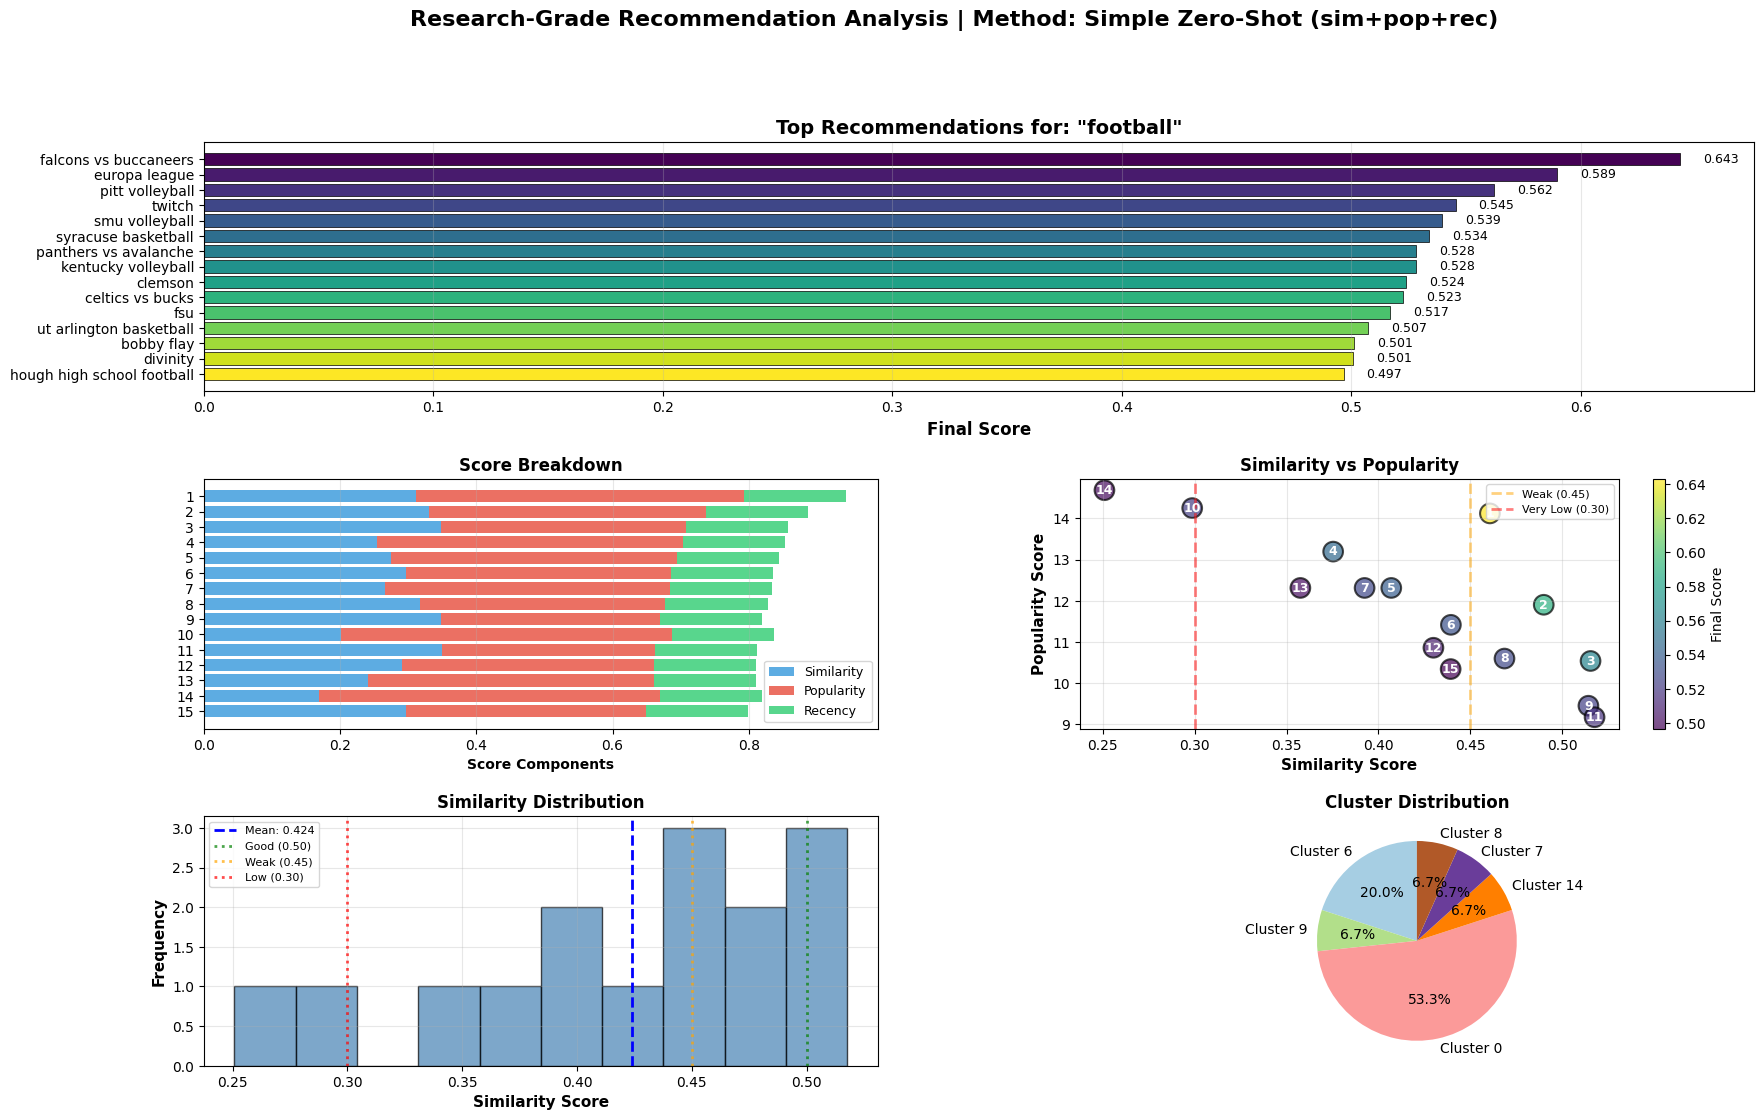


Embedding Space Visualization (PCA)


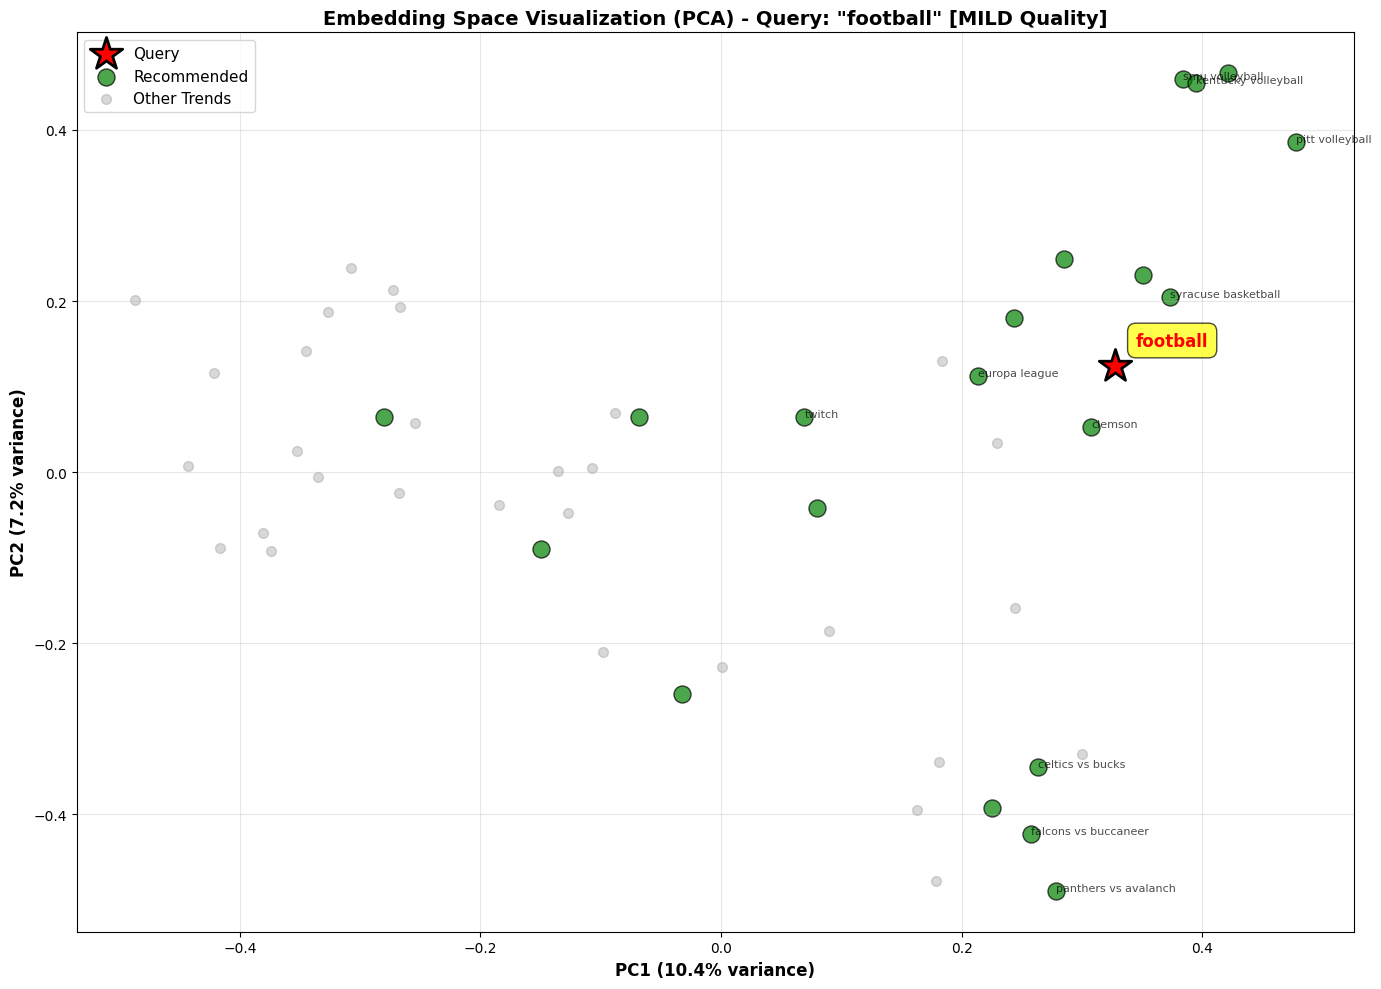

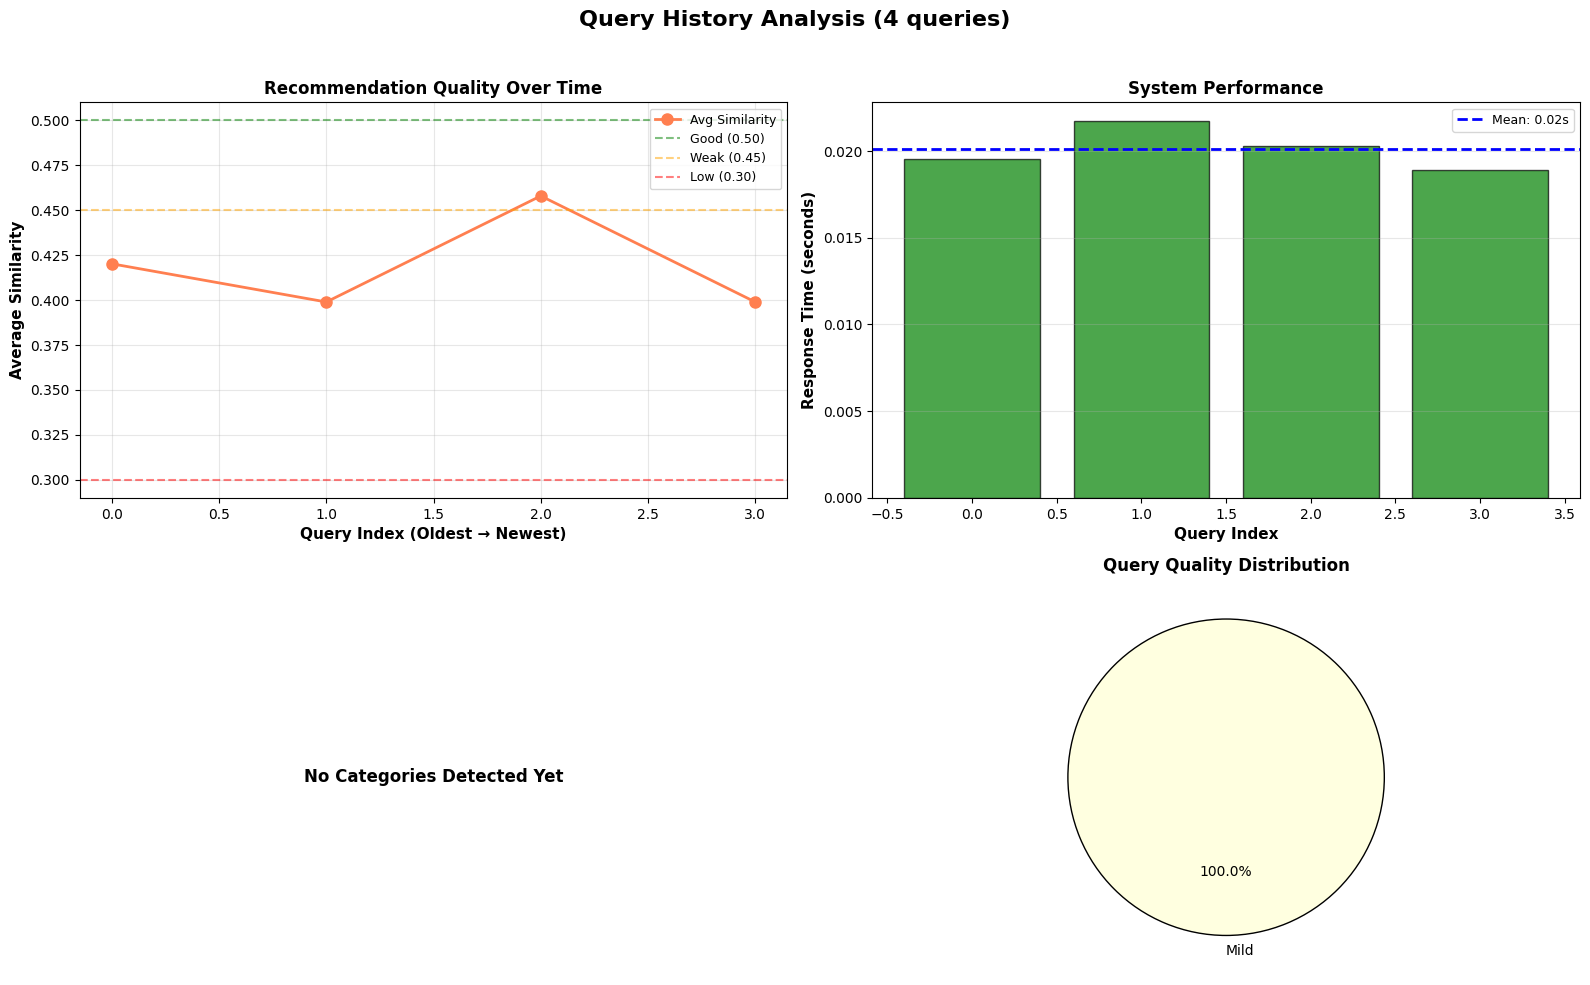

Query history visualization complete
Recommendation Completed!


In [ ]:
########################################
## cell 15     Main     Sunghyun Kim
########################################

try:
    # csv_path = '/content/sample_data/trending_US_7d_20251208-2254.csv'
    #csv_path = '/content/sample_data/trending_US_7d_20251209-1936.csv'
    # real-time data
    loader.load_df(df_trends_realtime)
    all_keywords = loader.get_keywords()

    if not all_keywords:
        raise ValueError("Empty keyword list")

    recommender.set_loader(loader)

except Exception as e:
    print(f"Error loading CSV: {e}")
    raise


try:
    cluster_engine.build_clusters(all_keywords, n_clusters=15)

    if cluster_engine.n_clusters == 0:
        print("Clustering failed.")

except Exception as e:
    print(f"Clustering error: {e}")

print("\n")
print("="*70)
print("Enter Your Interest Category")
print("="*70)

user_category = input("Your interest: ").strip()
if not user_category:
    raise ValueError("Please enter your input.")

compare_keyword = input("Compare keyword (optional, just Enter to skip): ").strip()
if compare_keyword == "":
    compare_keyword = None

try:
    response = run_query_with_defaults(
        user_category=user_category,
        top_k=20,
        compare_keyword=compare_keyword,
    )

    if response.get('status') == 'success' and response.get('results'):

        score_analysis = evaluator.analyze_score_distribution(response)

        if 'error' not in score_analysis:
            for metric, stats in score_analysis.items():
                if stats:
                    print(f"\n{metric.replace('_', ' ').title()}:")
                    for key, value in stats.items():
                        print(f"  • {key}: {value:.3f}")

    if response.get('status') == 'success' and response.get('results'):
        try:
            visualizer.plot_comprehensive_analysis(response)
        except Exception as e:
            print(f"Visualization error: {e}")

        print("\nEmbedding Space Visualization (PCA)")
        try:
            visualizer.plot_embedding_space_pca(response, all_keywords)
        except Exception as e:
            print(f"PCA visualization error: {e}")

        if len(recommender.query_logs) >= 2:
            try:
                visualizer.plot_query_history(recommender)
            except Exception as e:
                print(f"History visualization error: {e}")
        else:
            print("\nQuery history visualization available after more than 2 queries")

    print("Recommendation Completed!")

except Exception as e:
    print(f"\nUnexpected error: {e}")
    print("\nPlease check your inputs and try again.")
    import traceback
    traceback.print_exc()

In [ ]:
439########################################
## cell 17     Testing     Sunghyun Kim
########################################

# # Test after several queries
# eval_df = evaluator.generate_evaluation_report()

# Evaluation & Benchmark

demo_queries = [
    ("user_001", "technology news"),
    ("user_002", "sports"),
    ("user_003", "kpop"),
    ("user_004", "finance stock market"),
    ("user_005", "movies"),
]

for uid, category in demo_queries:
    _ = recommender.recommend(
        user_category=category,
        keywords=all_keywords,
        top_k=20,
    )

eval_df = evaluator.generate_evaluation_report()

test_cases = [
    ("technology", 0),
    ("sports", 1),
    ("kpop", 2),
]

benchmark_df = evaluator.run_benchmark(test_cases, all_keywords)



Weights: α=0.7, β=0.2, γ=0.1
Mode: SPECIFIC (force_mode=None)
MODERATE - Limited Direct Matches
Similarity Analysis:
   • Max Similarity: 0.430
   • Top 10 Average: 0.369
   • Mean Similarity: 0.124
   • Issue: Limited direct matches found

Min similarity threshold = 0.250
Filtered: 57/1761 keywords above threshold

Returned 20 keywords
Weights: α=0.6, β=0.3, γ=0.1
Mode: BROAD (force_mode=None)
Below-Average Quality
Similarity Analysis:
   • Max Similarity: 0.612
   • Top 10 Average: 0.555
   • Mean Similarity: 0.219
   • Issue: Overall similarity is below average

Min similarity threshold = 0.250
Filtered: 579/1761 keywords above threshold

Returned 20 keywords
Weights: α=0.6, β=0.3, γ=0.1
Mode: BROAD (force_mode=None)
MODERATE - Limited Direct Matches
Similarity Analysis:
   • Max Similarity: 0.466
   • Top 10 Average: 0.431
   • Mean Similarity: 0.149
   • Issue: Limited direct matches found

Min similarity threshold = 0.250
Filtered: 184/1761 keywords above threshold

Returned 20 k

In [ ]:
########################################
## cell 8  Interactive Control Panel     Sunghyun Kim
########################################

import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics.pairwise import cosine_similarity


txt_query = widgets.Text(
    value="football",
    placeholder="Enter interest keyword",
    description="Query:",
    layout=widgets.Layout(width="400px")
)

txt_compare = widgets.Text(
    value="falcons vs buccaneers",
    description="Compare:",
    layout=widgets.Layout(width="400px")
)

slider_alpha = widgets.FloatSlider(
    value=0.60, min=0.0, max=1.0, step=0.05,
    description="α(sim)",
    readout_format=".2f", continuous_update=False
)

slider_beta = widgets.FloatSlider(
    value=0.30, min=0.0, max=1.0, step=0.05,
    description="β(pop)",
    readout_format=".2f", continuous_update=False
)

slider_gamma = widgets.FloatSlider(
    value=0.10, min=0.0, max=1.0, step=0.05,
    description="γ(rec)",
    readout_format=".2f", continuous_update=False
)

slider_min_sim = widgets.FloatSlider(
    value=0.25, min=0.0, max=1.0, step=0.01,
    description="min sim",
    readout_format=".2f", continuous_update=False
)

slider_topk = widgets.IntSlider(
    value=20, min=5, max=50, step=1,
    description="Top K",
    continuous_update=False
)


btn_run = widgets.Button(
    description="Run Recommendation",
    button_style="success",
    icon="play"
)


# recency
slider_rec_decay = widgets.FloatSlider(
    value=0.10, min=0.0, max=0.5, step=0.01,
    description="rec_decay",
    readout_format=".2f", continuous_update=False
)

slider_rec_scale = widgets.FloatSlider(
    value=100.0, min=10.0, max=200.0, step=5.0,
    description="rec_scale",
    readout_format=".1f", continuous_update=False
)

# popularity model
slider_pop_decay = widgets.FloatSlider(
    value=0.03, min=0.0, max=0.5, step=0.01,
    description="pop_decay",
    readout_format=".2f", continuous_update=False
)

slider_volume_scale = widgets.FloatSlider(
    value=30.0, min=1.0, max=60.0, step=1.0,
    description="vol_scale",
    readout_format=".0f", continuous_update=False
)

slider_view_slope = widgets.FloatSlider(
    value=2.0, min=0.0, max=5.0, step=0.1,
    description="view_slope",
    readout_format=".1f", continuous_update=False
)

slider_view_max = widgets.FloatSlider(
    value=20.0, min=0.0, max=50.0, step=1.0,
    description="view_max",
    readout_format=".0f", continuous_update=False
)

slider_len_base = widgets.FloatSlider(
    value=100.0, min=10.0, max=200.0, step=10.0,
    description="len_base",
    readout_format=".0f", continuous_update=False
)

slider_uni_bonus = widgets.FloatSlider(
    value=20.0, min=0.0, max=50.0, step=1.0,
    description="uniq_bonus",
    readout_format=".0f", continuous_update=False
)

slider_word_penalty = widgets.FloatSlider(
    value=10.0, min=0.0, max=30.0, step=1.0,
    description="word_penalty",
    readout_format=".0f", continuous_update=False
)

output = widgets.Output()



def run_recommendation(_):
    with output:
        clear_output(wait=True)

        query = txt_query.value.strip()
        if not query:
            return

        trend_keywords = loader.get_keywords()
        if not trend_keywords:
            return

        alpha = slider_alpha.value
        beta = slider_beta.value
        gamma = slider_gamma.value

        top_k = int(slider_topk.value)
        min_sim = float(slider_min_sim.value)

        recommender.recency_decay_rate = float(slider_rec_decay.value)
        recommender.recency_scale = float(slider_rec_scale.value)

        popularity_model.decay_lambda = float(slider_pop_decay.value)
        popularity_model.volume_scale = float(slider_volume_scale.value)
        popularity_model.view_bonus_slope = float(slider_view_slope.value)
        popularity_model.view_bonus_max = float(slider_view_max.value)
        popularity_model.length_base = float(slider_len_base.value)
        popularity_model.uniqueness_bonus = float(slider_uni_bonus.value)
        popularity_model.common_word_penalty = float(slider_word_penalty.value)

        print("=" * 80)
        print(f"Query: '{query}'")
        print(f"Weights → α(sim)={alpha:.2f}, β(pop)={beta:.2f}, γ(rec)={gamma:.2f}")
        print(f"Top K = {top_k}, min_sim = {min_sim:.2f}")
        print("- Advanced Params -")
        print(f"  recency_decay = {recommender.recency_decay_rate:.2f}, "
              f"recency_scale = {recommender.recency_scale:.1f}")
        print(f"  pop_decay_lambda = {popularity_model.decay_lambda:.2f}")
        print(f"  volume_scale = {popularity_model.volume_scale:.1f}")
        print(f"  view_bonus_slope = {popularity_model.view_bonus_slope:.1f}, "
              f"view_bonus_max = {popularity_model.view_bonus_max:.1f}")
        print(f"  length_base = {popularity_model.length_base:.1f}, "
              f"uniq_bonus = {popularity_model.uniqueness_bonus:.1f}, "
              f"word_penalty = {popularity_model.common_word_penalty:.1f}")
        print("=" * 80)

        response = recommender.recommend(
            user_category=query,
            keywords=trend_keywords,
            top_k=top_k,
            similarity_weight=alpha,
            popularity_weight=beta,
            recency_weight=gamma,
        )

        recommender.display_results(response)

        try:
            comp = txt_compare.value.strip()
            if comp:
                emb_q = embedding_engine.encode(query)
                emb_c = embedding_engine.encode(comp)
                sim_pair = float(cosine_similarity([emb_q], [emb_c])[0][0])
                print(f"\n[Pairwise similarity] '{query}'  vs  '{comp}'  ->  {sim_pair:.3f}")
        except Exception as e:
            print(f"")

btn_run.on_click(run_recommendation)


basic_controls = widgets.VBox([
    txt_query,
    txt_compare,
    widgets.HBox([slider_alpha, slider_beta]),
    widgets.HBox([slider_gamma, slider_topk]),
    widgets.HBox([slider_min_sim]),
    btn_run,
])

advanced_controls = widgets.VBox([
    widgets.HTML("<b>Recency</b>"),
    widgets.HBox([slider_rec_decay, slider_rec_scale]),
    widgets.HTML("<b>Popularity Model</b>"),
    widgets.HBox([slider_pop_decay, slider_volume_scale]),
    widgets.HBox([slider_view_slope, slider_view_max]),
    widgets.HBox([slider_len_base, slider_uni_bonus, slider_word_penalty]),
])

accordion = widgets.Accordion(children=[advanced_controls])
accordion.set_title(0, "Advanced Hyperparameters")

ui = widgets.VBox([
    basic_controls,
    accordion,
    widgets.Label(""),
    output
])

display(ui)
